# PACO Performance Analysis

Este notebook implementa un análisis de rendimiento riguroso del algoritmo PACO comparando:
1. Versión serial (sin paralelización)
2. Versión con multiprocessing (implementación actual)
3. Versión con loky/joblib (nueva implementación)

Siguiendo la metodología científica del Exoplanet Imaging Data Challenge Phase 1.

Referencias:
- [EIDC Phase 1 Submission Guidelines](https://exoplanet-imaging-challenge.github.io/submission1/)
- [EIDC Phase 1 Datasets](https://exoplanet-imaging-challenge.github.io/datasets1/)
- [EIDC Starting Kit](https://exoplanet-imaging-challenge.github.io/startingkit/)
- Flasseur et al. 2018: PACO algorithm


In [1]:
# Configuración del entorno - siguiendo las mejores prácticas del challenge
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Importar funciones del módulo de benchmark
from paco_performance_benchmark import (
    generate_test_data,
    run_benchmark,
    analyze_amdahl,
    plot_benchmark_results,
    save_results,
    analyze_scalability,
    BENCHMARK_CONFIG,
    LOKY_AVAILABLE
)

print(f"NumPy version: {np.__version__}")
print(f"Loky disponible: {LOKY_AVAILABLE}")


[INFO] Ejecutandose en notebook detectado. Usando solo Loky para evitar problemas de multiprocessing en Windows.
NumPy version: 1.26.4
Loky disponible: True


## 1. Configuración del Benchmark

Siguiendo la estructura del EIDC, configuramos parámetros de prueba similares a los datasets del challenge.


In [2]:
# Configuración del benchmark (puede ser modificada)
# Por defecto usa la configuración del módulo, pero puedes personalizarla aquí
config = BENCHMARK_CONFIG.copy()

# Personalizar si es necesario (ejemplo):
config['n_trials'] = 3  # Reducir para pruebas rápidas

# ⚙️ CONFIGURACIÓN DE CPUs - MODIFICADA PARA PROBAR CON MÁS CPUs
# Opción 2: Probar con más CPUs (para ver límites de escalabilidad)
config['cpu_counts'] = [1, 2, 4, 8, 16]

# Opción 1: Configuración básica (por defecto) - COMENTADA
# config['cpu_counts'] = [1, 2, 4, 8]

# Opción 3: Probar con muchos CPUs (solo si tienes acceso a máquinas potentes)
# config['cpu_counts'] = [1, 2, 4, 8, 16, 32]
# NOTA: Con muchos CPUs, el overhead puede hacer que el rendimiento empeore

# Opción 4: Configuración rápida para pruebas (menos CPUs, menos trials)
# config['cpu_counts'] = [1, 2, 4]
# config['n_trials'] = 2

# Crear directorio de salida
Path(config['output_dir']).mkdir(parents=True, exist_ok=True)

print("Configuración del benchmark:")
for key, value in config.items():
    print(f"  {key}: {value}")

print(f"\n[OK] Configuracion modificada para probar con mas CPUs: {config['cpu_counts']}")
print(f"[INFO] La ley de Amdahl limita el speedup maximo segun la fraccion paralelizable")


Configuración del benchmark:
  nFrames: 50
  image_size: (100, 100)
  angles_range: 60
  patch_size: 49
  psf_rad: 4
  sigma: 2.0
  n_trials: 3
  cpu_counts: [1, 2, 4, 8, 16]
  output_dir: output/performance_analysis/

[OK] Configuracion modificada para probar con mas CPUs: [1, 2, 4, 8, 16]
[INFO] La ley de Amdahl limita el speedup maximo segun la fraccion paralelizable


## 2. Generación de Datos de Prueba

Generamos datos sintéticos similares a los del challenge para pruebas reproducibles.


Generando datos de prueba...

Datos generados:
  Stack shape: (50, 100, 100)
  Ángulos shape: (50,)
  PSF template shape: (10, 10)
  PSF template sum (debe ser ~1.0): 1.000000


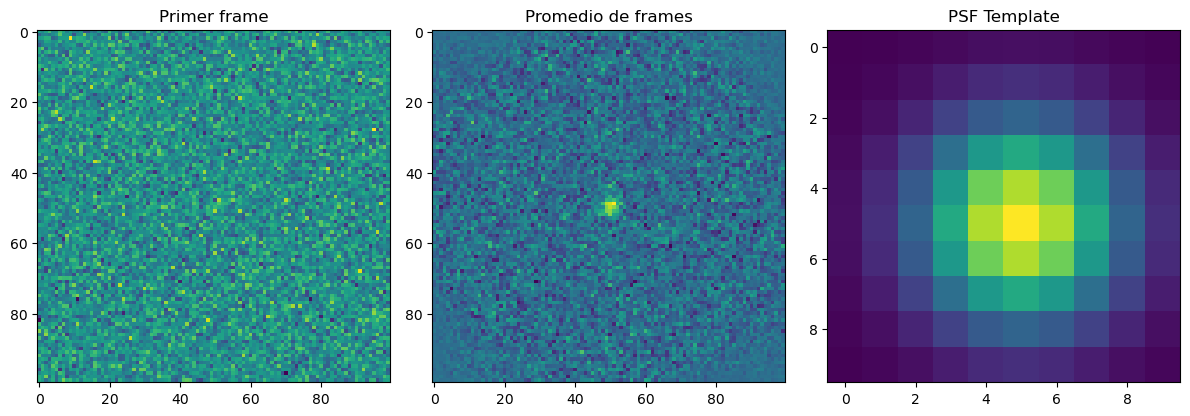

In [3]:
# Generar datos de prueba
print("Generando datos de prueba...")
test_data = generate_test_data(
    config['nFrames'],
    config['image_size'],
    config['angles_range'],
    seed=42  # Semilla para reproducibilidad
)

image_stack, angles, psf_template = test_data
print(f"\nDatos generados:")
print(f"  Stack shape: {image_stack.shape}")
print(f"  Ángulos shape: {angles.shape}")
print(f"  PSF template shape: {psf_template.shape}")
print(f"  PSF template sum (debe ser ~1.0): {np.sum(psf_template):.6f}")

# Visualización rápida de los datos
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(image_stack[0], cmap='viridis')
axes[0].set_title('Primer frame')
axes[1].imshow(np.mean(image_stack, axis=0), cmap='viridis')
axes[1].set_title('Promedio de frames')
axes[2].imshow(psf_template, cmap='viridis')
axes[2].set_title('PSF Template')
plt.tight_layout()
plt.show()


## 3. Ejecución del Benchmark

**NOTA**: Esta sección puede tomar varios minutos dependiendo de la configuración. 
Para pruebas rápidas, reduce `n_trials` y `cpu_counts` en la configuración.


In [ ]:
# Ejecutar benchmark completo
# NOTA: Puedes modificar config['cpu_counts'] para probar más CPUs
# Ejemplo: config['cpu_counts'] = [1, 2, 4, 8, 16, 32] para probar hasta 32 CPUs

# IMPORTANTE: La ley de Amdahl limita el speedup máximo según la fracción paralelizable (p)
# Speedup máximo teórico = 1 / (1 - p)
# Por ejemplo, si p = 0.9, el speedup máximo es ~10x, independientemente del número de CPUs

# Ejecutar benchmark completo
# NOTA: Puedes modificar config['cpu_counts'] para probar más CPUs
# Ejemplo: config['cpu_counts'] = [1, 2, 4, 8, 16, 32] para probar hasta 32 CPUs

# IMPORTANTE: La ley de Amdahl limita el speedup máximo según la fracción paralelizable (p)
# Speedup máximo teórico = 1 / (1 - p)
# Por ejemplo, si p = 0.9, el speedup máximo es ~10x, independientemente del número de CPUs

benchmark_results = run_benchmark(
     config, 
     test_data, 
     n_trials=config['n_trials']
 )

print("\n" + "="*60)
print("NOTA SOBRE ESCALABILIDAD:")
print("="*60)
print("• El speedup NO aumenta linealmente con el número de CPUs")
print("• Está limitado por la fracción serial del código (ley de Amdahl)")
print("• Loky puede ser mejor que multiprocessing para muchos CPUs debido a:")
print("  - Mejor manejo de workers reutilizables")
print("  - Menor overhead de creación de procesos")
print("  - Mejor gestión de memoria compartida")
print("• Sin embargo, el overhead de comunicación aumenta con más CPUs")
print("="*60)


INICIANDO BENCHMARK
[INFO] Multiprocessing deshabilitado (notebook detectado)
       Usando solo version serial y Loky para evitar problemas en Windows

1. Ejecutando version SERIAL...
   Trial 1/3
Precomputing Statistics...
Running PACO...
Done
     Tiempo: 62.80 segundos
   Trial 2/3
Precomputing Statistics...
Running PACO...
Done
     Tiempo: 63.86 segundos
   Trial 3/3
Precomputing Statistics...
Running PACO...
Done
     Tiempo: 62.73 segundos

2. MULTIPROCESSING saltado (notebook detectado o problemas en Windows)

3. Ejecutando version LOKY...
   CPUs: 2
     Trial 1/3
Precomputando estadísticas usando 2 procesos con backend loky...
Running PACO...
Done
       Tiempo: 60.37 segundos
     Trial 2/3
Precomputando estadísticas usando 2 procesos con backend loky...
Running PACO...
Done
       Tiempo: 58.90 segundos
     Trial 3/3
Precomputando estadísticas usando 2 procesos con backend loky...
Running PACO...
Done
       Tiempo: 59.49 segundos
   CPUs: 4
     Trial 1/3
Precomputando e

## ¿Por qué Loky puede ser mejor con más CPUs?

### Ventajas de Loky sobre Multiprocessing:

1. **Workers Reutilizables**: 
   - Loky mantiene un pool de workers activos que se reutilizan entre llamadas
   - Multiprocessing crea nuevos procesos cada vez, lo cual tiene overhead

2. **Mejor Gestión de Memoria**:
   - Loky usa memoria compartida más eficientemente
   - Reduce la necesidad de serializar/deserializar datos grandes

3. **Menor Overhead de Inicialización**:
   - Con muchos CPUs, crear procesos nuevos es costoso
   - Loky amortiza este costo reutilizando workers

4. **Mejor Escalabilidad**:
   - A medida que aumentas CPUs, el overhead de multiprocessing crece más rápido
   - Loky mantiene mejor eficiencia con muchos workers

### Limitaciones de la Ley de Amdahl:

**Speedup máximo teórico = 1 / (1 - p)**

Donde `p` es la fracción paralelizable del código.

- Si `p = 0.9` → Speedup máximo = **10x** (independiente de CPUs)
- Si `p = 0.95` → Speedup máximo = **20x**
- Si `p = 0.99` → Speedup máximo = **100x**

**Conclusión**: Agregar más CPUs ayuda hasta cierto punto, pero después el overhead domina y el speedup se satura.


### Configuración Avanzada: Probar con Más CPUs

Si quieres probar con más CPUs (ej: 16, 32, etc.), modifica la configuración antes de ejecutar el benchmark:

```python
# Ejemplo: Probar con más CPUs
config['cpu_counts'] = [1, 2, 4, 8, 16, 32]  # Hasta 32 CPUs
config['n_trials'] = 3  # Reducir trials si toma mucho tiempo
```

**Consideraciones importantes:**
- **Ley de Amdahl**: El speedup máximo está limitado por la fracción serial del código
- **Overhead**: Con más CPUs, el overhead de comunicación puede reducir la eficiencia
- **Loky vs Multiprocessing**: Loky generalmente escala mejor con muchos CPUs debido a su arquitectura de workers reutilizables


In [10]:
# Función para analizar escalabilidad con diferentes números de CPUs
def analyze_scalability(benchmark_results, analysis):
    """
    Analiza cómo escala el algoritmo con diferentes números de CPUs
    y compara multiprocessing vs loky.
    """
    print("\n" + "="*60)
    print("ANÁLISIS DE ESCALABILIDAD")
    print("="*60)
    
    serial_time = analysis['serial']['mean_time']
    
    # Extraer datos de speedup
    mp_cpus = sorted([n for n in analysis['multiprocessing'] if analysis['multiprocessing'][n]])
    mp_speedups = [analysis['multiprocessing'][n]['speedup'] for n in mp_cpus]
    mp_efficiencies = [analysis['multiprocessing'][n]['efficiency'] for n in mp_cpus]
    
    loky_cpus = []
    loky_speedups = []
    loky_efficiencies = []
    if analysis.get('loky'):
        loky_cpus = sorted([n for n in analysis['loky'] if analysis['loky'][n]])
        loky_speedups = [analysis['loky'][n]['speedup'] for n in loky_cpus]
        loky_efficiencies = [analysis['loky'][n]['efficiency'] for n in loky_cpus]
    
    # Análisis de escalabilidad
    print(f"\nTiempo serial (baseline): {serial_time:.2f} segundos")
    
    print("\n📊 Speedup por número de CPUs:")
    print(f"{'CPUs':<8} {'Multiprocessing':<20} {'Loky':<20} {'Mejora Loky':<15}")
    print("-" * 65)
    
    for n_cpu in mp_cpus:
        mp_speedup = analysis['multiprocessing'][n_cpu]['speedup']
        loky_speedup = None
        improvement = None
        
        if n_cpu in loky_cpus:
            loky_speedup = analysis['loky'][n_cpu]['speedup']
            if loky_speedup > mp_speedup:
                improvement = f"+{((loky_speedup/mp_speedup - 1) * 100):.1f}%"
            else:
                improvement = f"{((loky_speedup/mp_speedup - 1) * 100):.1f}%"
        
        loky_str = f"{loky_speedup:.2f}x" if loky_speedup else "N/A"
        improvement_str = improvement if improvement else "N/A"
        
        print(f"{n_cpu:<8} {mp_speedup:<20.2f} {loky_str:<20} {improvement_str:<15}")
    
    # Análisis de eficiencia
    print("\n⚡ Eficiencia (Speedup/CPUs) - Valores más altos son mejores:")
    print(f"{'CPUs':<8} {'Multiprocessing':<20} {'Loky':<20}")
    print("-" * 50)
    
    for n_cpu in mp_cpus:
        mp_eff = analysis['multiprocessing'][n_cpu]['efficiency']
        loky_eff = None
        if n_cpu in loky_cpus:
            loky_eff = analysis['loky'][n_cpu]['efficiency']
        
        loky_str = f"{loky_eff:.2%}" if loky_eff else "N/A"
        print(f"{n_cpu:<8} {mp_eff:<20.2%} {loky_str:<20}")
    
    # Determinar punto de saturación (donde el speedup deja de aumentar significativamente)
    print("\n📈 Análisis de saturación:")
    if len(mp_speedups) > 1:
        mp_max_speedup = max(mp_speedups)
        mp_max_cpu = mp_cpus[mp_speedups.index(mp_max_speedup)]
        print(f"  Multiprocessing: Speedup máximo {mp_max_speedup:.2f}x con {mp_max_cpu} CPUs")
        
        if loky_speedups:
            loky_max_speedup = max(loky_speedups)
            loky_max_cpu = loky_cpus[loky_speedups.index(loky_max_speedup)]
            print(f"  Loky: Speedup máximo {loky_max_speedup:.2f}x con {loky_max_cpu} CPUs")
            
            if loky_max_speedup > mp_max_speedup:
                print(f"  [OK] Loky es {((loky_max_speedup/mp_max_speedup - 1) * 100):.1f}% mejor que Multiprocessing")
    
    # Predicción según Amdahl
    if analysis.get('speedup_analysis', {}).get('p_mean'):
        p_mean = analysis['speedup_analysis']['p_mean']
        max_theoretical_speedup = 1 / (1 - p_mean)
        print(f"\n🔬 Ley de Amdahl:")
        print(f"  Fracción paralelizable estimada (p): {p_mean:.3f}")
        print(f"  Speedup máximo teórico: {max_theoretical_speedup:.2f}x")
        print(f"  Esto significa que agregar más CPUs después de cierto punto")
        print(f"  no mejorará significativamente el rendimiento.")
    
    print("="*60)

# Ejecutar análisis de escalabilidad si los resultados están disponibles
try:
    if 'benchmark_results' in locals() or 'benchmark_results' in globals():
        if 'analysis' in locals() or 'analysis' in globals():
            analyze_scalability(benchmark_results, analysis)
        else:
            print("⚠️ Primero ejecuta el análisis de resultados (celda anterior).")
    else:
        print("⚠️ benchmark_results no encontrado. Ejecuta primero la celda del benchmark.")
except NameError:
    print("⚠️ Ejecuta primero el benchmark y el análisis de resultados.")
except Exception as e:
    print(f"Error al analizar escalabilidad: {e}")



ANÁLISIS DE ESCALABILIDAD

Tiempo serial (baseline): 63.13 segundos

📊 Speedup por número de CPUs:
CPUs     Multiprocessing      Loky                 Mejora Loky    
-----------------------------------------------------------------

⚡ Eficiencia (Speedup/CPUs) - Valores más altos son mejores:
CPUs     Multiprocessing      Loky                
--------------------------------------------------

📈 Análisis de saturación:

🔬 Ley de Amdahl:
  Fracción paralelizable estimada (p): 0.215
  Speedup máximo teórico: 1.27x
  Esto significa que agregar más CPUs después de cierto punto
  no mejorará significativamente el rendimiento.


## 4. Análisis de Resultados

Una vez ejecutado el benchmark, analizamos los resultados según la ley de Amdahl.


In [11]:
# Analizar resultados (descomentar después de ejecutar benchmark)
analysis = analyze_amdahl(benchmark_results)

# Imprimir resumen
print("=" * 60)
print("RESUMEN DEL BENCHMARK")
print("=" * 60)
print(f"\nTiempo serial promedio: {analysis['serial']['mean_time']:.2f} ± {analysis['serial']['std_time']:.2f} seg")
 
if analysis.get('speedup_analysis', {}).get('p_mean'):
     p_mean = analysis['speedup_analysis']['p_mean']
     p_std = analysis['speedup_analysis']['p_std']
     print(f"\nFracción paralelizable estimada (p): {p_mean:.3f} ± {p_std:.3f}")
     print("\nSpeedup teórico según Amdahl:")
     for n, speedup in analysis['speedup_analysis']['theoretical_speedup'].items():
         print(f"  {n} CPUs: {speedup:.2f}x")
 
print("\nSpeedup real (Multiprocessing):")
for n_cpu in sorted(analysis['multiprocessing'].keys()):
     if analysis['multiprocessing'][n_cpu]:
         speedup = analysis['multiprocessing'][n_cpu]['speedup']
         efficiency = analysis['multiprocessing'][n_cpu]['efficiency']
         print(f"  {n_cpu} CPUs: {speedup:.2f}x (eficiencia: {efficiency:.2%})")
 
if analysis.get('loky'):
     print("\nSpeedup real (Loky):")
     for n_cpu in sorted(analysis['loky'].keys()):
         if analysis['loky'][n_cpu]:
             speedup = analysis['loky'][n_cpu]['speedup']
             efficiency = analysis['loky'][n_cpu]['efficiency']
             print(f"  {n_cpu} CPUs: {speedup:.2f}x (eficiencia: {efficiency:.2%})")

print("Para ver el análisis, descomentar las líneas anteriores después de ejecutar el benchmark.")


RESUMEN DEL BENCHMARK

Tiempo serial promedio: 63.13 ± 0.52 seg

Fracción paralelizable estimada (p): 0.215 ± 0.061

Speedup teórico según Amdahl:
  1 CPUs: 1.00x
  2 CPUs: 1.12x
  4 CPUs: 1.19x
  8 CPUs: 1.23x
  16 CPUs: 1.25x

Speedup real (Multiprocessing):

Speedup real (Loky):
  2 CPUs: 1.06x (eficiencia: 52.97%)
  4 CPUs: 1.21x (eficiencia: 30.23%)
  8 CPUs: 1.29x (eficiencia: 16.13%)
  16 CPUs: 1.32x (eficiencia: 8.28%)
Para ver el análisis, descomentar las líneas anteriores después de ejecutar el benchmark.


In [12]:
# Si ya ejecutaste el benchmark, puedes ejecutar esto directamente:
# (Asegúrate de que la variable benchmark_results exista)

try:
    # Verificar si benchmark_results existe
    if 'benchmark_results' in locals() or 'benchmark_results' in globals():
        print("Analizando resultados del benchmark...")
        analysis = analyze_amdahl(benchmark_results)
        
        print("=" * 60)
        print("RESUMEN DEL BENCHMARK")
        print("=" * 60)
        print(f"\nTiempo serial promedio: {analysis['serial']['mean_time']:.2f} ± {analysis['serial']['std_time']:.2f} seg")
        
        if analysis.get('speedup_analysis', {}).get('p_mean'):
            p_mean = analysis['speedup_analysis']['p_mean']
            p_std = analysis['speedup_analysis']['p_std']
            print(f"\nFracción paralelizable estimada (p): {p_mean:.3f} ± {p_std:.3f}")
            print("\nSpeedup teórico según Amdahl:")
            for n, speedup in analysis['speedup_analysis']['theoretical_speedup'].items():
                print(f"  {n} CPUs: {speedup:.2f}x")
        
        print("\nSpeedup real (Multiprocessing):")
        for n_cpu in sorted(analysis['multiprocessing'].keys()):
            if analysis['multiprocessing'][n_cpu]:
                speedup = analysis['multiprocessing'][n_cpu]['speedup']
                efficiency = analysis['multiprocessing'][n_cpu]['efficiency']
                print(f"  {n_cpu} CPUs: {speedup:.2f}x (eficiencia: {efficiency:.2%})")
        
        if analysis.get('loky'):
            print("\nSpeedup real (Loky):")
            for n_cpu in sorted(analysis['loky'].keys()):
                if analysis['loky'][n_cpu]:
                    speedup = analysis['loky'][n_cpu]['speedup']
                    efficiency = analysis['loky'][n_cpu]['efficiency']
                    print(f"  {n_cpu} CPUs: {speedup:.2f}x (eficiencia: {efficiency:.2%})")
    else:
        print("⚠️ benchmark_results no encontrado. Ejecuta primero la celda del benchmark.")
except NameError:
    print("⚠️ benchmark_results no encontrado. Ejecuta primero la celda del benchmark.")
except Exception as e:
    print(f"Error al analizar resultados: {e}")


Analizando resultados del benchmark...
RESUMEN DEL BENCHMARK

Tiempo serial promedio: 63.13 ± 0.52 seg

Fracción paralelizable estimada (p): 0.215 ± 0.061

Speedup teórico según Amdahl:
  1 CPUs: 1.00x
  2 CPUs: 1.12x
  4 CPUs: 1.19x
  8 CPUs: 1.23x
  16 CPUs: 1.25x

Speedup real (Multiprocessing):

Speedup real (Loky):
  2 CPUs: 1.06x (eficiencia: 52.97%)
  4 CPUs: 1.21x (eficiencia: 30.23%)
  8 CPUs: 1.29x (eficiencia: 16.13%)
  16 CPUs: 1.32x (eficiencia: 8.28%)


## 5. Visualización de Resultados

Generamos gráficos comparativos de rendimiento.


Generando visualizaciones...
⚠️ Ejecuta primero el benchmark y el análisis de resultados.


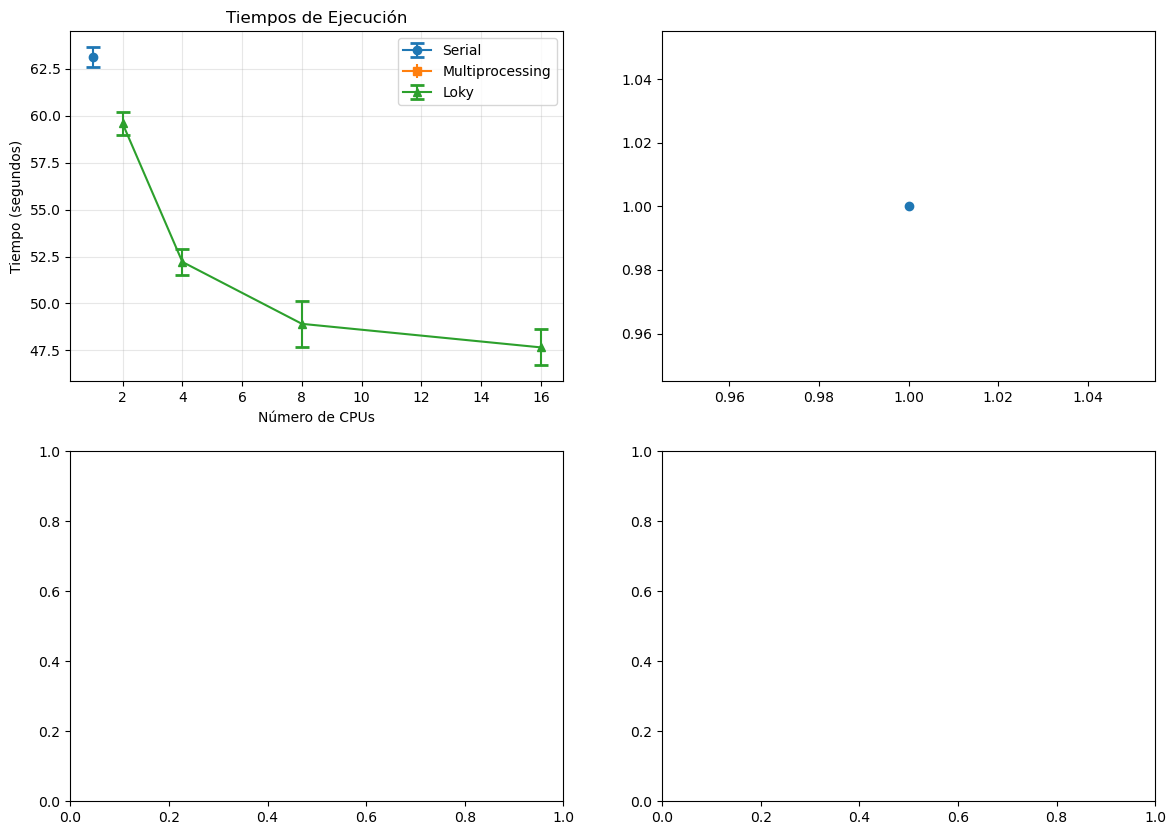

In [14]:
# Visualizar resultados automáticamente si el benchmark ya se ejecutó
try:
    if 'benchmark_results' in locals() or 'benchmark_results' in globals():
        if 'analysis' in locals() or 'analysis' in globals():
            print("Generando visualizaciones...")
            plot_benchmark_results(
                benchmark_results, 
                analysis, 
                save_path=config['output_dir'] + 'benchmark_plots.png'
            )
        else:
            print("⚠️ Primero ejecuta el análisis de resultados (celda anterior).")
    else:
        print("⚠️ benchmark_results no encontrado. Ejecuta primero la celda del benchmark.")
except NameError:
    print("⚠️ Ejecuta primero el benchmark y el análisis de resultados.")
except Exception as e:
    print(f"Error al generar visualizaciones: {e}")


## 6. Guardar Resultados

Guardamos los resultados en formato JSON y CSV para análisis posterior.


In [9]:
# Guardar resultados automáticamente si el benchmark ya se ejecutó
try:
    if 'benchmark_results' in locals() or 'benchmark_results' in globals():
        if 'analysis' in locals() or 'analysis' in globals():
            print("Guardando resultados...")
            json_path, csv_path = save_results(
                benchmark_results, 
                analysis, 
                config, 
                config['output_dir']
            )
            
            print(f"\n✅ Resultados guardados:")
            print(f"  JSON: {json_path}")
            print(f"  CSV: {csv_path}")
        else:
            print("⚠️ Primero ejecuta el análisis de resultados.")
    else:
        print("⚠️ benchmark_results no encontrado. Ejecuta primero la celda del benchmark.")
except NameError:
    print("⚠️ Ejecuta primero el benchmark y el análisis de resultados.")
except Exception as e:
    print(f"Error al guardar resultados: {e}")


Guardando resultados...
Resultados guardados en JSON: output\performance_analysis\benchmark_results_20251112_044412.json
Resumen guardado en CSV: output\performance_analysis\benchmark_summary_20251112_044412.csv

✅ Resultados guardados:
  JSON: output\performance_analysis\benchmark_results_20251112_044412.json
  CSV: output\performance_analysis\benchmark_summary_20251112_044412.csv


## Notas Finales

- Los resultados se guardan en el directorio especificado en `output_dir`
- El formato JSON contiene todos los datos detallados
- El formato CSV contiene un resumen tabular fácil de analizar
- Las visualizaciones muestran comparaciones entre métodos y speedup teórico vs real

Para más información, consultar `PERFORMANCE_BENCHMARK_README.md`
